# Описание проекта: телекоммуникации

**Общая информация**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно;
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
* За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

**Цели и задачи проекта**

Основной целью проекта является прогнозирование оттока клиентов. В ходе достижения данной цели будут решены следующие задачи:
* Анализ и предобработка данных: необходимо провести исследовательский анализ данных и выявить возможные проблемы (например, отсутствующие значения) и исправить их. Также требуется преобразовать категориальные признаки в числовые, если это необходимо для обучения моделей машинного обучения.

* Создание модели машинного обучения: необходимо выбрать модель машинного обучения (например, логистическую регрессию, случайный лес, градиентный бустинг и так далее) и настроить ее параметры для достижения наилучшего значения целевой метрики.

* Интерпретация результатов работы наилучшей модели.

## Исследовательский анализ данных

In [1]:
!pip install phik
import phik

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from re import sub

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 12345

def plot_roc_curve(target_test, predictions):
    print('ROC-AUC score', roc_auc_score(target_test, predictions))
    
    fpr, tpr, thresholds = roc_curve(target_test, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

Импорт необходимых библиотек.

In [2]:
try:
    contract_data = pd.read_csv('contract_new.csv')
    personal_data = pd.read_csv('personal_new.csv')
    internet_data = pd.read_csv('internet_new.csv')
    phone_data = pd.read_csv('phone_new.csv')
    
except FileNotFoundError:
    contract_data = pd.read_csv('/datasets/contract_new.csv')
    personal_data = pd.read_csv('/datasets/personal_new.csv')
    internet_data = pd.read_csv('/datasets/internet_new.csv')
    phone_data = pd.read_csv('/datasets/phone_new.csv')

Загрузка данных.

In [3]:
def view_data(df):
    print('Общий вид датафрейма:')
    display(df.head())
    print('Описательная статистика:')
    display(df.describe())
    print('Информация о датафрейме:')
    display(df.info())
    print('Количество пропусков:')
    display(df.isna().sum())

Функция для вывода общей информация о датасете.

In [4]:
def snake_case(s):
    return '_'.join(
        sub('([A-Z][a-z]+)', r' \1',
        sub('([A-Z]+)', r' \1',
        s.replace('-', ' '))).split()).lower()

Функция для преобразования названия столбца в snake_case

### Информация о договоре

In [5]:
view_data(contract_data)

Общий вид датафрейма:


customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5

Описательная статистика:


MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Количество пропусков:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

**Вывод**:
* В данных нет пропусков;
* Названия столбцов желательно привести к snake_case;
* Столбцы BeginDate и EndDate необходимо конвертировать в datetime;
* В случае, если значение в EndDate равняется No, необходимо его заменить на 01.02.2020 (так как клиент до сих пор пользуется услугами);
* TotalCharges нужно конвертировать в float64;
* К столбцам Type, PaperlessBilling и PaymentMethod необходимо применить OHE;

### Персональные данные клиента

In [6]:
view_data(personal_data)

Общий вид датафрейма:


customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

Описательная статистика:


SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Количество пропусков:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

**Вывод**:
* В данных нет пропусков;
* Названия столбцов желательно привести к snake_case;
* К столбцам Gender, Partner и Dependents необходимо применить OHE;

### Информация об интернет-услугах

In [7]:
view_data(internet_data)

Общий вид датафрейма:


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

Описательная статистика:


customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     8824-RWFXJ     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Количество пропусков:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

**Вывод**:
* В данных нет пропусков;
* Названия столбцов желательно привести к snake_case;
* Ко всем столбцам, кроме customerID, необходимо применить OHE;

### Информация об услугах телефонии

In [8]:
view_data(phone_data)

Общий вид датафрейма:


customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

Описательная статистика:


customerID MultipleLines
count         6361          6361
unique        6361             2
top     8824-RWFXJ            No
freq             1          3390

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Количество пропусков:


customerID       0
MultipleLines    0
dtype: int64

**Вывод**:
* В данных нет пропусков;
* Названия столбцов желательно привести к snake_case;
* К столбцу MultipleLines необходимо применить OHE;

### Вопросы

* Какую метрику использовать для оценки моделей?
* Какое знчение целевой метрики является удовлетворительным?

### План работы

* **Предобработка данных на основе полученной информации**.

Переименование столбцов к snake_case. Объединение данных из разных файлов, путем сопоставления их по общему идентификатору клиента.

* **Изучение данных**. 

Более детальный анализ данных в каждом из приложенных файлов. Выделение важных признаков и удаление ненужных.

* **Подбор лучшей модели**. 

Преобразование категориальных признаков в числовые при помощи техники кодирования OHE. Построение нескольких моделей машинного обучения, таких как логистическая регрессия, случайный лес или градиентный бустинг. Настройка гиперпараметров моделей для достижения наилучшего результата. Сравнение их производительности на основе целевой метрики оценивания. 
* **Вывод**.

Анализ полученных результатов, подведение итогов работы, описание возникших сложностей и проблем.

## Предобработка данных

In [9]:
contract_data.rename(columns=snake_case, inplace=True)
list(contract_data.columns)

['customer_id',
 'begin_date',
 'end_date',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges']

In [10]:
personal_data.rename(columns=snake_case, inplace=True)
list(personal_data.columns)

['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

In [11]:
internet_data.rename(columns=snake_case, inplace=True)
list(internet_data.columns)

['customer_id',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies']

In [12]:
phone_data.rename(columns=snake_case, inplace=True)
list(phone_data.columns)

['customer_id', 'multiple_lines']

Приведение названий столбцов датафреймов к snake_case.

In [13]:
contract_data['churn'] = (contract_data['end_date'] != 'No').astype(int)
contract_data.head()

customer_id  begin_date end_date            type paperless_billing  \
0  7590-VHVEG  2020-01-01       No  Month-to-month               Yes   
1  5575-GNVDE  2017-04-01       No        One year                No   
2  3668-QPYBK  2019-10-01       No  Month-to-month               Yes   
3  7795-CFOCW  2016-05-01       No        One year                No   
4  9237-HQITU  2019-09-01       No  Month-to-month               Yes   

              payment_method  monthly_charges total_charges  churn  
0           Electronic check            29.85         31.04      0  
1               Mailed check            56.95       2071.84      0  
2               Mailed check            53.85        226.17      0  
3  Bank transfer (automatic)            42.30        1960.6      0  
4           Electronic check            70.70         353.5      0

Добавление целевого признака churn. Если пользователь закончил пользоваться услугами, целевой признак равен одному, иначе - нулю.

In [14]:
contract_data['end_date'] = contract_data['end_date'].replace(['No'], ['2020-02-01'])
contract_data.head()

customer_id  begin_date    end_date            type paperless_billing  \
0  7590-VHVEG  2020-01-01  2020-02-01  Month-to-month               Yes   
1  5575-GNVDE  2017-04-01  2020-02-01        One year                No   
2  3668-QPYBK  2019-10-01  2020-02-01  Month-to-month               Yes   
3  7795-CFOCW  2016-05-01  2020-02-01        One year                No   
4  9237-HQITU  2019-09-01  2020-02-01  Month-to-month               Yes   

              payment_method  monthly_charges total_charges  churn  
0           Electronic check            29.85         31.04      0  
1               Mailed check            56.95       2071.84      0  
2               Mailed check            53.85        226.17      0  
3  Bank transfer (automatic)            42.30        1960.6      0  
4           Electronic check            70.70         353.5      0

Заменяем значения в столбце end_date на дату '2020-02-01', если пользователь не закончил пользоваться услугами.

In [15]:
for col in ['begin_date', 'end_date']:
    contract_data[col] = pd.to_datetime(contract_data[col], format='%Y-%m-%d')

contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   churn              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


Конвертация begin_date и end_date в datetime.

In [16]:
contract_data['total_days'] = (contract_data['end_date'] - contract_data['begin_date']).dt.days

Новый признак total_days, показывающий то, сколько человек пользовался услугами оператора.

In [17]:
contract_data['total_charges'] = pd.to_numeric(contract_data['total_charges'], errors ='coerce')
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   churn              7043 non-null   int64         
 9   total_days         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


Приведение столбца total_charges к числовому типу.

In [18]:
contract_data.isnull().sum()

customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
churn                 0
total_days            0
dtype: int64

После приведения к числовому типу появились пропуски.

In [19]:
contract_data[contract_data['total_charges'].isnull()]

customer_id begin_date   end_date      type paperless_billing  \
488   4472-LVYGI 2020-02-01 2020-02-01  Two year               Yes   
753   3115-CZMZD 2020-02-01 2020-02-01  Two year                No   
936   5709-LVOEQ 2020-02-01 2020-02-01  Two year                No   
1082  4367-NUYAO 2020-02-01 2020-02-01  Two year                No   
1340  1371-DWPAZ 2020-02-01 2020-02-01  Two year                No   
3331  7644-OMVMY 2020-02-01 2020-02-01  Two year                No   
3826  3213-VVOLG 2020-02-01 2020-02-01  Two year                No   
4380  2520-SGTTA 2020-02-01 2020-02-01  Two year                No   
5218  2923-ARZLG 2020-02-01 2020-02-01  One year               Yes   
6670  4075-WKNIU 2020-02-01 2020-02-01  Two year                No   
6754  2775-SEFEE 2020-02-01 2020-02-01  Two year               Yes   

                 payment_method  monthly_charges  total_charges  churn  \
488   Bank transfer (automatic)            52.55            NaN      0   
753                Mailed check            20.25            NaN      0   
936                Mailed check            80.85            NaN      0   
1082               Mailed check            25.75            NaN      0   
1340    Credit card (automatic)            56.05            NaN      0   
3331               Mailed check            19.85            NaN      0   
3826               Mailed check            25.35            NaN      0   
4380               Mailed check            20.00            NaN      0   
5218               Mailed check            19.70            NaN      0   
6670               Mailed check            73.35            NaN      0   
6754  Bank transfer (automatic)            61.90            NaN      0   

      total_days  
488            0  
753            0  
936            0  
1082           0  
1340           0  
3331           0  
3826           0  
4380           0  
5218           0  
6670           0  
6754           0

Пропуски в строках, где пользователь подключен всего-лишь один день. Заменим пропуски в столбце total_charges на нули.

In [20]:
contract_data['total_charges'] = contract_data['total_charges'].fillna(0)
contract_data.isnull().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
total_days           0
dtype: int64

In [21]:
churn_data = contract_data \
    .merge(personal_data, how='left', on='customer_id') \
    .merge(internet_data, how='left', on='customer_id') \
    .merge(phone_data, how='left', on='customer_id') 

Соединяем датафреймы по столбцу customer_id.

In [22]:
churn_data = churn_data.set_index('customer_id')
view_data(churn_data)

Общий вид датафрейма:


begin_date   end_date            type paperless_billing  \
customer_id                                                           
7590-VHVEG  2020-01-01 2020-02-01  Month-to-month               Yes   
5575-GNVDE  2017-04-01 2020-02-01        One year                No   
3668-QPYBK  2019-10-01 2020-02-01  Month-to-month               Yes   
7795-CFOCW  2016-05-01 2020-02-01        One year                No   
9237-HQITU  2019-09-01 2020-02-01  Month-to-month               Yes   

                        payment_method  monthly_charges  total_charges  churn  \
customer_id                                                                     
7590-VHVEG            Electronic check            29.85          31.04      0   
5575-GNVDE                Mailed check            56.95        2071.84      0   
3668-QPYBK                Mailed check            53.85         226.17      0   
7795-CFOCW   Bank transfer (automatic)            42.30        1960.60      0   
9237-HQITU            Electronic check            70.70         353.50      0   

             total_days  gender  ...  partner dependents internet_service  \
customer_id                      ...                                        
7590-VHVEG           31  Female  ...      Yes         No              DSL   
5575-GNVDE         1036    Male  ...       No         No              DSL   
3668-QPYBK          123    Male  ...       No         No              DSL   
7795-CFOCW         1371    Male  ...       No         No              DSL   
9237-HQITU          153  Female  ...       No         No      Fiber optic   

            online_security online_backup device_protection tech_support  \
customer_id                                                                
7590-VHVEG               No           Yes                No           No   
5575-GNVDE              Yes            No               Yes           No   
3668-QPYBK              Yes           Yes                No           No   
7795-CFOCW              Yes            No               Yes          Yes   
9237-HQITU               No            No                No           No   

            streaming_tv streaming_movies multiple_lines  
customer_id                                               
7590-VHVEG            No               No            NaN  
5575-GNVDE            No               No             No  
3668-QPYBK            No               No             No  
7795-CFOCW            No               No            NaN  
9237-HQITU            No               No             No  

[5 rows x 21 columns]

Описательная статистика:


monthly_charges  total_charges        churn   total_days  \
count      7043.000000    7043.000000  7043.000000  7043.000000   
mean         64.761692    2115.312885     0.156325   898.555729   
std          30.090047    2112.742814     0.363189   683.130510   
min          18.250000       0.000000     0.000000     0.000000   
25%          35.500000     436.750000     0.000000   276.000000   
50%          70.350000    1343.350000     0.000000   761.000000   
75%          89.850000    3236.690000     0.000000  1461.000000   
max         118.750000    9221.380000     1.000000  2314.000000   

       senior_citizen  
count     7043.000000  
mean         0.162147  
std          0.368612  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          1.000000

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   churn              7043 non-null   int64         
 8   total_days         7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   5517 non-

None

Количество пропусков:


begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn                   0
total_days              0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Пропуски в указанных столбцах выше обусловены тем, что, скорее всего, данные услуги не подключены. Заменим пропуски на 'No'.

In [23]:
for column in ('internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'):
    churn_data[column] = churn_data[column].fillna('No')
    
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   churn              7043 non-null   int64         
 8   total_days         7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14

## Изучение данных

In [24]:
numeric_features = [
    'monthly_charges', 
    'total_charges', 
    'total_days'
]

categorical_features = [
    'type',
    'paperless_billing',
    'payment_method',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'internet_service', 
    'online_security', 
    'online_backup', 
    'device_protection', 
    'tech_support', 
    'streaming_tv', 
    'streaming_movies', 
    'multiple_lines',
]

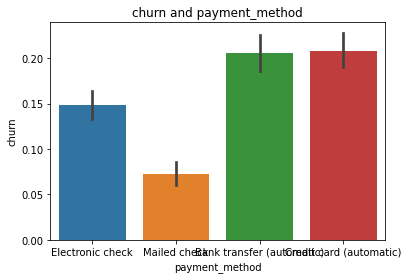

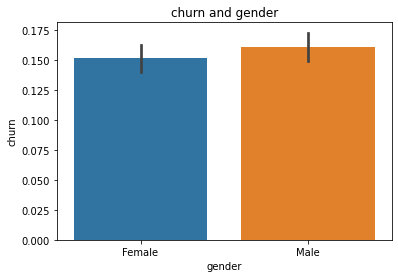

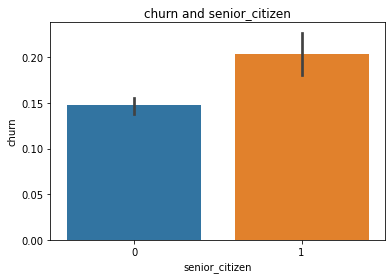

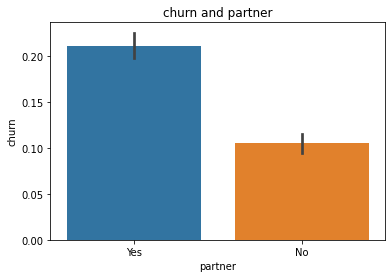

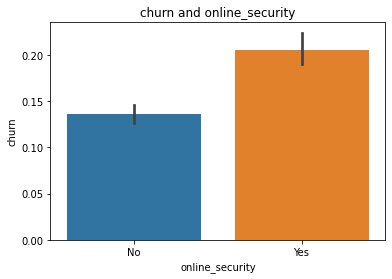

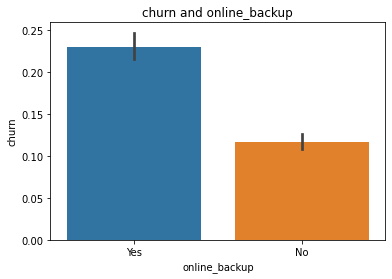

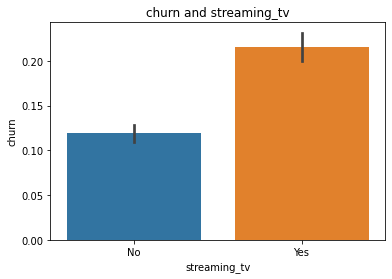

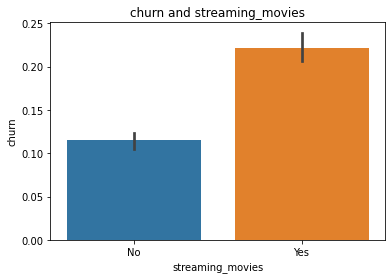

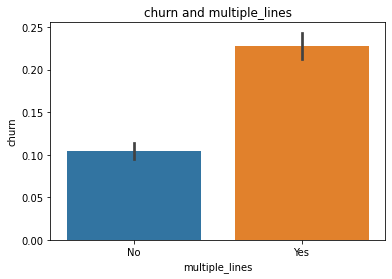

In [25]:
for feature in categorical_features:
    sns.barplot(x=feature, y='churn', data=churn_data)
    plt.xlabel(feature)
    plt.ylabel('churn')
    plt.title(f'churn and {feature}')
    plt.show()

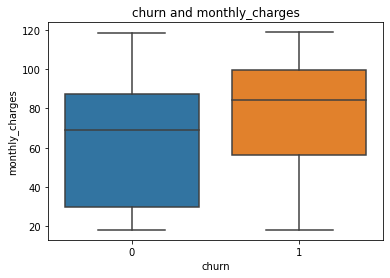

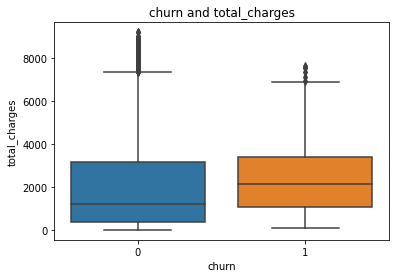

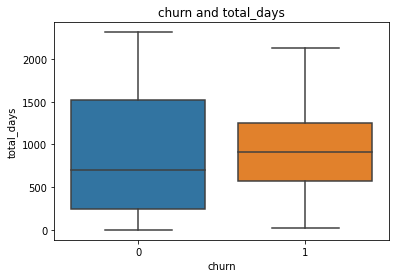

In [26]:
for feature in numeric_features:
    sns.boxplot(x='churn', y=feature, data=churn_data)
    plt.xlabel('churn')
    plt.ylabel(feature)
    plt.title(f'churn and {feature}')
    plt.show()

In [27]:
churn_data[numeric_features].corr()

monthly_charges  total_charges  total_days
monthly_charges         1.000000       0.630440    0.220054
total_charges           0.630440       1.000000    0.821746
total_days              0.220054       0.821746    1.000000

Заметна мультиколлинеарность в данных - корреляция между total_charges и total_days - 0.82. Удалим столбец total_charges.

In [28]:
del churn_data['total_charges']
del numeric_features[1]

interval columns not set, guessing: ['monthly_charges', 'churn', 'total_days', 'senior_citizen']


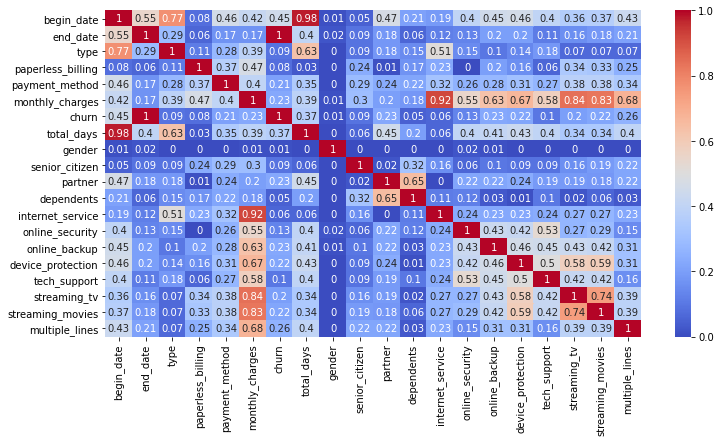

In [29]:
phik_matrix = churn_data.phik_matrix().round(2)
plt.figure(figsize=(12, 6))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
plt.show()

## Подбор модели

In [30]:
del churn_data['begin_date'], churn_data['end_date']

Удаление ненужных столбцов.

In [31]:
features = churn_data.drop(columns=['churn'])
target = churn_data['churn']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
encoder_ohe.fit(features_train[categorical_features])
features_train[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train[categorical_features])
features_train = features_train.drop(categorical_features, axis=1)
scaler = StandardScaler()
features_train[numeric_features] = scaler.fit_transform(features_train[numeric_features])
features_train.head()

/tmp/ipykernel_404/2080959457.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train[categorical_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


monthly_charges  total_days  x0_One year  x0_Two year  x1_Yes  \
customer_id                                                                  
0422-OHQHQ         -1.475875   -0.656713          1.0          0.0     0.0   
6656-GULJQ          0.617064    1.886545          0.0          1.0     1.0   
8967-SZQAS         -0.482560   -0.700714          0.0          0.0     0.0   
6711-VTNRE          0.749949    0.413978          0.0          0.0     1.0   
5913-INRQV          0.836324    0.192506          1.0          0.0     0.0   

             x2_Credit card (automatic)  x2_Electronic check  x2_Mailed check  \
customer_id                                                                     
0422-OHQHQ                          0.0                  0.0              1.0   
6656-GULJQ                          1.0                  0.0              0.0   
8967-SZQAS                          0.0                  1.0              0.0   
6711-VTNRE                          0.0                  1.0              0.0   
5913-INRQV                          0.0                  0.0              1.0   

             x3_Male  x4_1  ...  x6_Yes  x7_Fiber optic  x7_No  x8_Yes  \
customer_id                 ...                                          
0422-OHQHQ       0.0   0.0  ...     1.0             0.0    1.0     0.0   
6656-GULJQ       1.0   0.0  ...     1.0             0.0    0.0     1.0   
8967-SZQAS       0.0   0.0  ...     0.0             0.0    0.0     0.0   
6711-VTNRE       0.0   0.0  ...     0.0             1.0    0.0     0.0   
5913-INRQV       1.0   1.0  ...     0.0             1.0    0.0     1.0   

             x9_Yes  x10_Yes  x11_Yes  x12_Yes  x13_Yes  x14_Yes  
customer_id                                                       
0422-OHQHQ      0.0      0.0      0.0      0.0      0.0      0.0  
6656-GULJQ      0.0      1.0      1.0      1.0      1.0      1.0  
8967-SZQAS      1.0      0.0      0.0      0.0      0.0      0.0  
6711-VTNRE      0.0      1.0      1.0      0.0      1.0      0.0  
5913-INRQV      0.0      0.0      1.0      1.0      0.0      0.0  

[5 rows x 21 columns]

Кодирование категориальных признаков методом OHE.

In [32]:
features_test[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test[categorical_features])
features_test = features_test.drop(categorical_features, axis=1)
features_test[numeric_features] = scaler.transform(features_test[numeric_features])
features_test.head()

/tmp/ipykernel_404/1569238018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test[categorical_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


monthly_charges  total_days  x0_One year  x0_Two year  x1_Yes  \
customer_id                                                                  
0098-BOWSO         -1.514079   -0.121368          0.0          0.0     1.0   
9992-RRAMN          0.668557   -1.016055          0.0          0.0     1.0   
8380-PEFPE          0.221731   -1.102590          0.0          0.0     1.0   
9773-PEQBZ          0.494145   -0.878185          0.0          0.0     0.0   
8319-QBEHW         -0.831383   -0.165369          1.0          0.0     1.0   

             x2_Credit card (automatic)  x2_Electronic check  x2_Mailed check  \
customer_id                                                                     
0098-BOWSO                          0.0                  1.0              0.0   
9992-RRAMN                          0.0                  1.0              0.0   
8380-PEFPE                          0.0                  1.0              0.0   
9773-PEQBZ                          0.0                  1.0              0.0   
8319-QBEHW                          0.0                  0.0              0.0   

             x3_Male  x4_1  ...  x6_Yes  x7_Fiber optic  x7_No  x8_Yes  \
customer_id                 ...                                          
0098-BOWSO       1.0   0.0  ...     0.0             0.0    1.0     0.0   
9992-RRAMN       1.0   0.0  ...     0.0             1.0    0.0     0.0   
8380-PEFPE       1.0   0.0  ...     1.0             1.0    0.0     0.0   
9773-PEQBZ       1.0   0.0  ...     0.0             1.0    0.0     0.0   
8319-QBEHW       1.0   0.0  ...     1.0             0.0    0.0     0.0   

             x9_Yes  x10_Yes  x11_Yes  x12_Yes  x13_Yes  x14_Yes  
customer_id                                                       
0098-BOWSO      0.0      0.0      0.0      0.0      0.0      0.0  
9992-RRAMN      0.0      0.0      0.0      0.0      1.0      1.0  
8380-PEFPE      0.0      0.0      0.0      0.0      0.0      0.0  
9773-PEQBZ      1.0      0.0      0.0      0.0      0.0      1.0  
8319-QBEHW      1.0      0.0      0.0      1.0      0.0      0.0  

[5 rows x 21 columns]

**LogisticRegression**

In [33]:
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

lr_model = LogisticRegression(solver='lbfgs', n_jobs=-1)

lr_search = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='roc_auc')
lr_search.fit(features_train, target_train)

print(f'Лучшие параметры: {lr_search.best_params_}')
print(f'Лучшее значение: {lr_search.best_score_}')

Лучшие параметры: {'C': 1000}
Лучшее значение: 0.750709001538315


**CatBoostClassifier**

In [35]:
cb_param_grid = {
    'learning_rate': [0.1, 0.3],
    'iterations': [50, 100],
    'l2_leaf_reg': [3, 9]
}

cb_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

cb_search = GridSearchCV(cb_model, cb_param_grid, cv=5, scoring='roc_auc')
cb_search.fit(features_train, target_train)

print(f'Лучшие параметры: {cb_search.best_params_}')
print(f'Лучшее значение: {cb_search.best_score_}')

Лучшие параметры: {'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.3}
Лучшее значение: 0.8979019009579492


**RandomForestClassifier**

In [37]:
rf_param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100], 
}

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='roc_auc')
rf_search.fit(features_train, target_train)

print(f'Лучшие параметры: {rf_search.best_params_}')
print(f'Лучшее значение: {rf_search.best_score_}')

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Лучшее значение: 0.8145349284158556


Лучшее значение целевой метрики показала модель CatBoost. Построим ROC-кривую. Узнаем важность признаков.

ROC-AUC score 0.9199379900579102


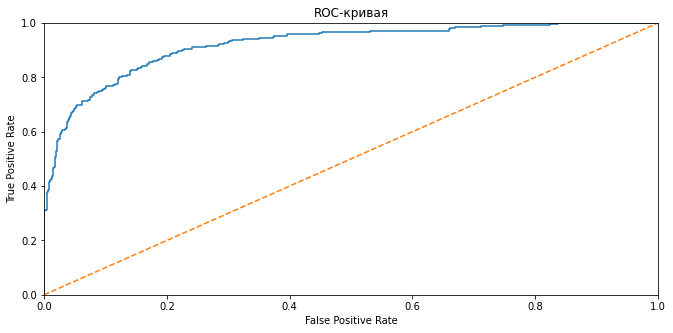

In [40]:
cb_predicted_probalities = cb_search.best_estimator_.predict_proba(features_test)[:, 1]
plot_roc_curve(target_test, cb_predicted_probalities)

In [39]:
imp = pd.DataFrame(cb_search.best_estimator_.feature_importances_, index = features_test.columns, columns=['importance'])
imp = imp.sort_values(by='importance', ascending=False)
imp

importance
total_days                   51.011924
monthly_charges              12.170539
x0_Two year                   5.158011
x5_Yes                        4.405082
x0_One year                   4.186882
x14_Yes                       2.692867
x9_Yes                        2.439833
x2_Mailed check               2.050165
x4_1                          1.981592
x1_Yes                        1.581094
x12_Yes                       1.576499
x10_Yes                       1.574739
x2_Electronic check           1.554239
x8_Yes                        1.486306
x6_Yes                        1.374777
x2_Credit card (automatic)    1.296200
x13_Yes                       1.120981
x11_Yes                       0.915021
x3_Male                       0.698855
x7_Fiber optic                0.646332
x7_No                         0.078060

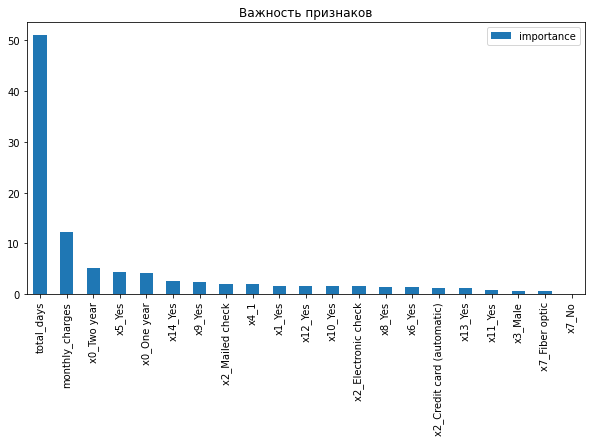

In [41]:
imp.plot(kind='bar', figsize=(10, 5), title='Важность признаков')
plt.show()

In [42]:
predicted_target = cb_search.best_estimator_.predict(features_test)
confusion_matrix(target_test, predicted_target)

array([[1474,   27],
       [ 129,  131]])

Матрица ошибок.

## Вывод 

Были проанализированы предоставленные данные и по результатам анализа были приняты решения по дальнейшей обработки данных.
В процессе предобработки данных были ереименованы столбцы (snake_case), изменены типы данных.

Были добавлены два новых признака - целевой признак churn, который означает, отказался ли клиент от услуг, и признак total_days, означающий, сколько дней пользователь использует услуги провайдера.

Была проведена подготовка данных к обучению моделей машинного обучения: удалены ненужные столбцы, категориальные признаки закодированы техникой OHE, было проведено масштабирование количественных признаков и upsampling.

Затем на данных были обучены 3 модели: LogisticRegression, CatBoostClassifier и RandomForestClassifier.

Лучший результат целевой метрики показала модель CatBoostClassifier, равный 0.9114.

Самые важные факторы - total_days - длительность пользования услугами, и monthly_charges - оплата в месяц.

## Отчет о проделанной работе

* В ходе работы над проектом были выполнены все пункты, описанные в первоначальном плане. Значение RANDOM_STATE для дальнейшей работы: 12345
* Возникли трудности с построением графика корелляции всех признаков датафрема, но данная проблема была успешно решена с помощью библиотеки *phik*. Также возникли трудности с корректным кодированием признаков методом OHE, тем не менее, проблема была решена - вместо *pd.get_dummies* использовался *OneHotEncoder*
* Ключевые шаги в решении задачи: анализ файлов, предобработка данных, исследовательский анализ, подбор параметров и обучение моделей.
* В ходе обучения модели категориальные признаки были закодированы методом OHE, также признаки *begin_date* и *end_date* были удалены.
* Лучшая модель: CatBoostClassifier. Ее параметры: {'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.3}. Значение целевой метрики на обучающих данных: 0.898, на тестовых: 0.919

**Визуализация ROC-кривой**
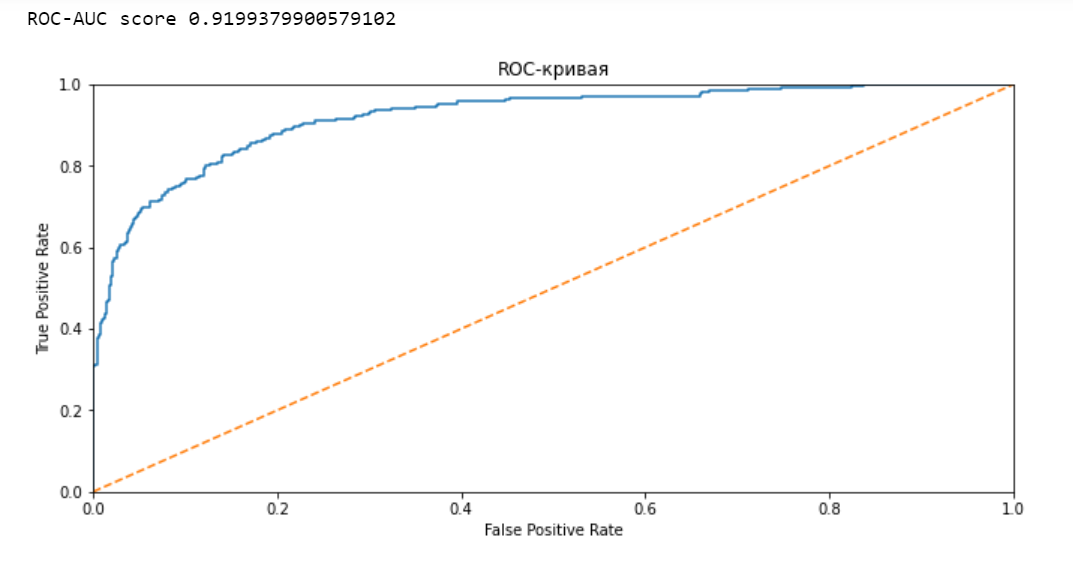

**Матрица ошибок**
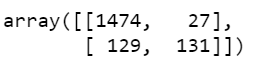

**Важность признаков**
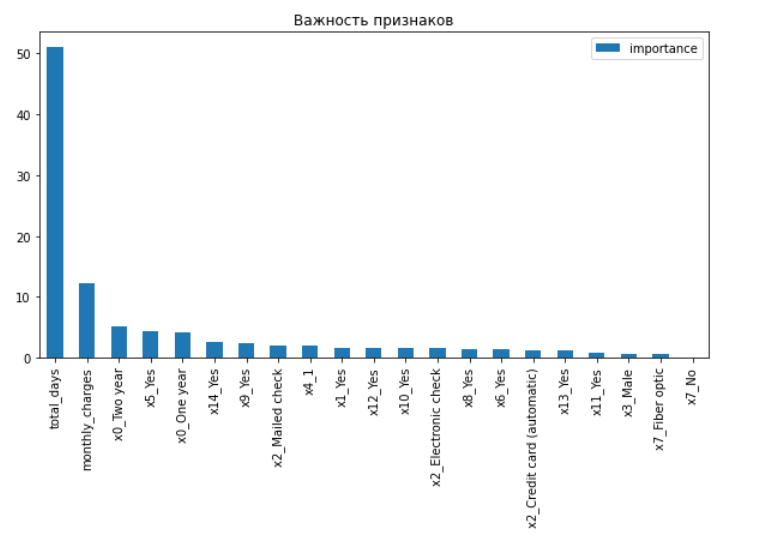